In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mplhep as hep
from io import BytesIO
import zstd

from datetime import datetime
import mplhep as hep

hep.style.use(hep.style.CMS)
from typing import Callable

In [2]:
with open('data.pkl.zst', 'rb') as f:
    df:pd.DataFrame = pd.read_pickle(BytesIO(zstd.decompress(f.read())))

In [3]:
def filter_df(df:pd.DataFrame, fn):
    mask = np.empty(len(df), dtype=np.bool_)
    for i, row in enumerate(df.itertuples()):
        mask[i] = fn(row)
    return df.iloc[mask]

In [4]:
# fdf = filter_df(df, lambda row: 'Experiment-HEP' in row.inspire_categories and row.earliest_date.year > 10)

In [5]:
subjects = ["Experiment-HEP", "Phenomenology-HEP", "Experiment-Nucl", "Instrumentation", "Theory-Nucl", "Astrophysics", "Lattice", "Theory-HEP", "Other", "General Physics", "Computing", "Accelerators", "Data Analysis and Statistics", "Gravitation and Cosmology", "Quantum Physics", "Condensed Matter", "Math and Math Physics"]

document_types = ["published", "article", "conference paper", "review", "introductory", "lectures", "book chapter", "note", "thesis", "book", "report", "proceedings"]


In [6]:
# all_dois = set()
# mask = np.zeros(len(df), dtype=np.bool_)
# for i, row in enumerate(df.itertuples()):
#     dois = row.dois
#     has_doi = False #or 'thesis' in row.document_type
#     for doi in dois:
#         has_doi = True
#         if dois in all_dois:
#             break
#         all_dois.add(doi)
#     else:
#         mask[i] = has_doi
# fdf = df.iloc[mask]

# len(fdf)

In [7]:
fdf = filter_df(df, lambda row: row.earliest_date.year > 1500)
len(fdf)

822779

In [8]:
y0, y1 = np.min(df.earliest_date).year, datetime.now().year
cnt = y1 - y0 + 1

In [9]:
len(filter_df(df, lambda row: row.earliest_date.year == 2020 and 'thesis' in row.document_type and 'Experiment-HEP' in row.inspire_categories))

488

In [10]:
from tqdm import tqdm
columns = []
df_arr = [[] for _ in range(len(subjects))]
for i,subject in enumerate(tqdm(subjects)):
    _fdf = filter_df(fdf, lambda row: subject in row.inspire_categories)
    thesis_mask = np.array(_fdf.document_type == {'thesis'})
    df_thesis = _fdf.iloc[thesis_mask]
    df_others = _fdf.iloc[~thesis_mask]
    df_arr[i] = [df_thesis, df_others]
    columns.append((subject, 'thesis'))
    columns.append((subject, 'others'))
    # break

100%|██████████| 17/17 [00:40<00:00,  2.38s/it]


In [16]:
master_arr = np.zeros((len(subjects), 2, cnt), dtype=np.int32)
for i,subject in enumerate(tqdm(subjects)):
    df_thesis, df_others = df_arr[i]
    df_others = df_others.query('citation_count >= 100')
    years_thesis = np.array([x.year for x in df_thesis.earliest_date])
    years_others = np.array([x.year for x in df_others.earliest_date])

    years_thesis = years_thesis
    years_others = years_others

    loc_t, v_t = np.unique(years_thesis, return_counts=True)
    loc_o, v_o = np.unique(years_others, return_counts=True)
    if len(loc_t):
        master_arr[i, 0][loc_t-y0] = v_t
    if len(loc_o):
        master_arr[i, 1][loc_o-y0] = v_o


100%|██████████| 17/17 [00:00<00:00, 70.24it/s]


In [17]:
_master_arr = master_arr.reshape(len(subjects)*2,-1).T
columns = columns = pd.MultiIndex.from_tuples(columns)
df_len = pd.DataFrame(data=_master_arr, columns=columns, index=np.arange(y0,y1+1))

In [18]:
for subject in tqdm(subjects):
    print(f"{subject:30}: {df_len[subject]['others'].sum()/df_len[subject]['thesis'].sum():02.2f}")

100%|██████████| 17/17 [00:00<00:00, 1085.66it/s]

Experiment-HEP                : 0.45
Phenomenology-HEP             : 2.54
Experiment-Nucl               : 0.76
Instrumentation               : 0.17
Theory-Nucl                   : 2.80
Astrophysics                  : 3.16
Lattice                       : 2.28
Theory-HEP                    : 2.08
Other                         : 0.82
General Physics               : 2.56
Computing                     : 0.34
Accelerators                  : 0.12
Data Analysis and Statistics  : 0.43
Gravitation and Cosmology     : 1.53
Quantum Physics               : 0.35
Condensed Matter              : 3.24
Math and Math Physics         : 0.68


100%|██████████| 17/17 [00:04<00:00,  4.04it/s]


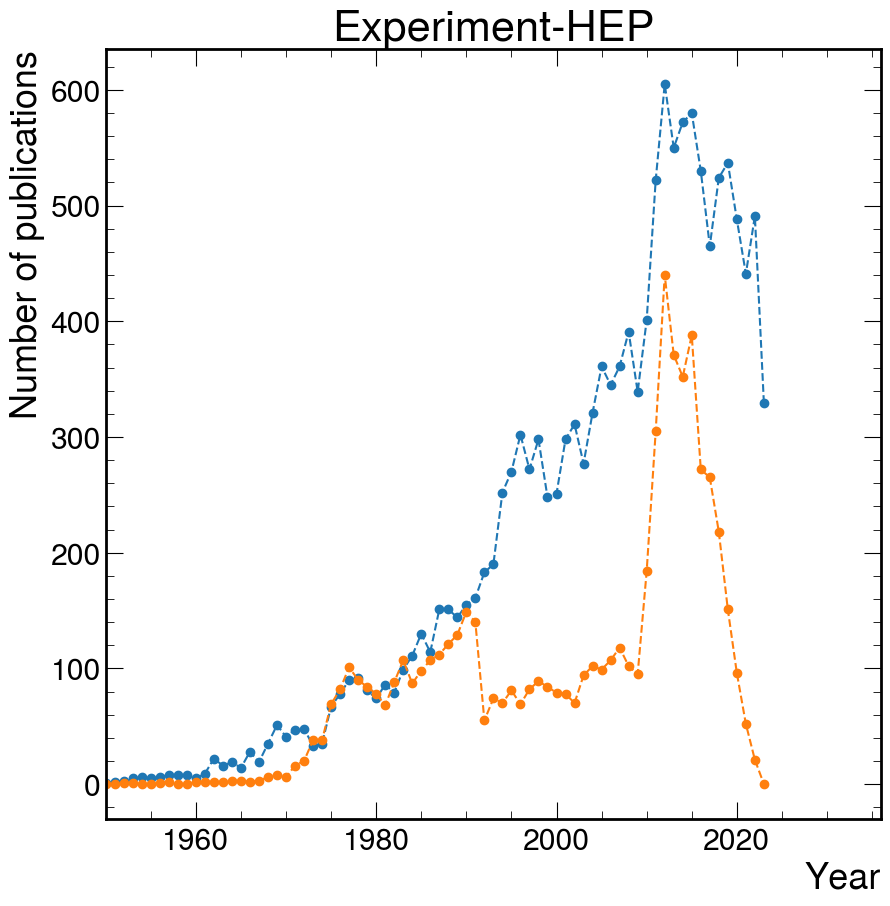

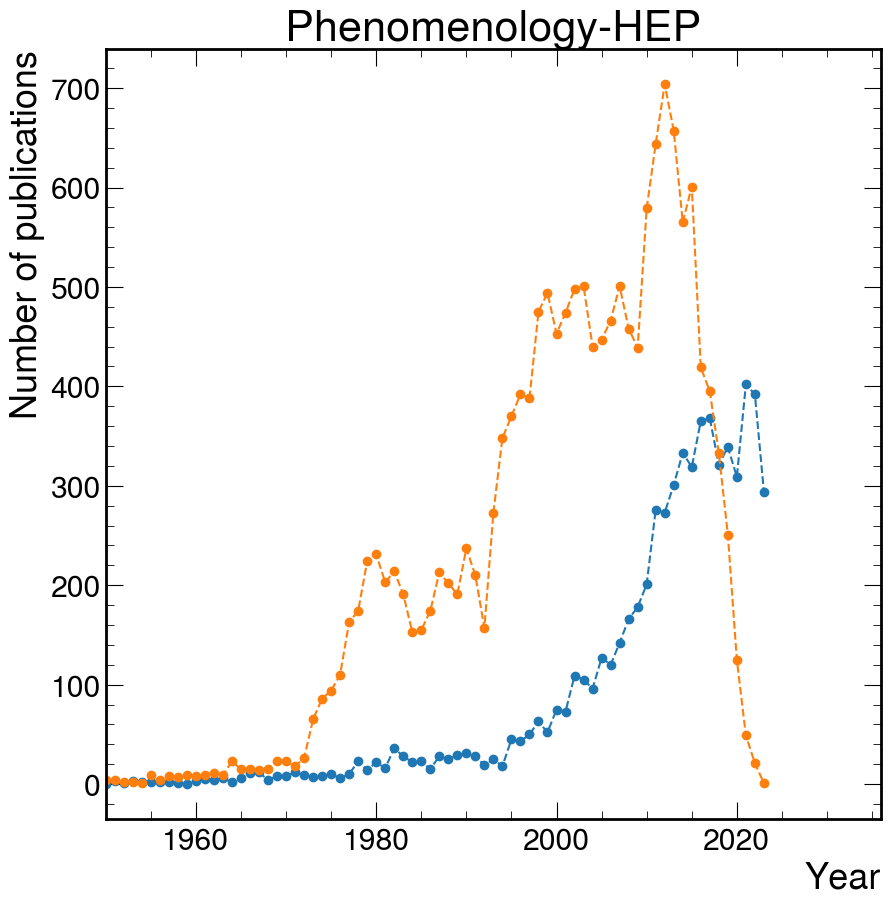

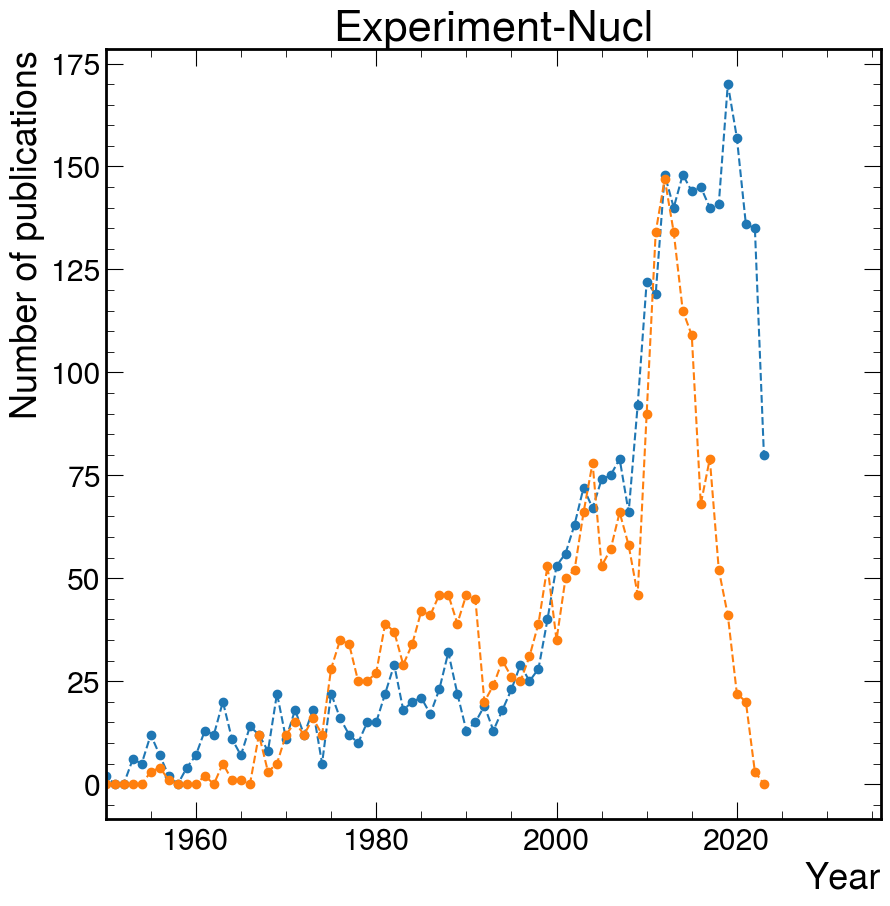

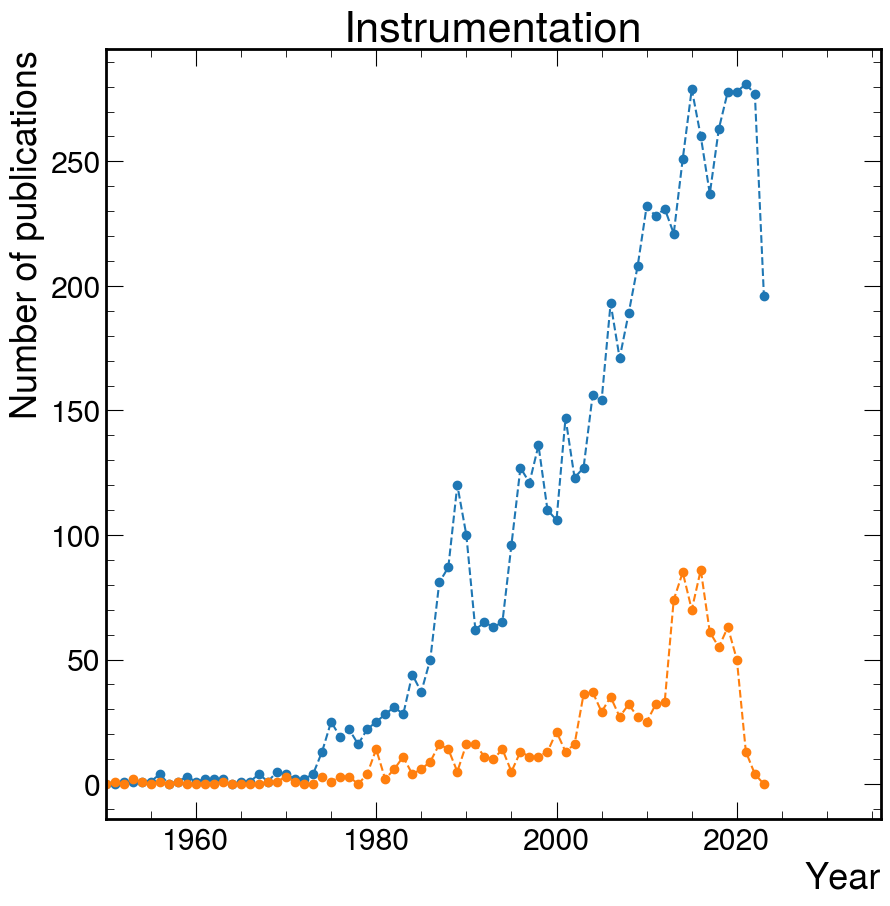

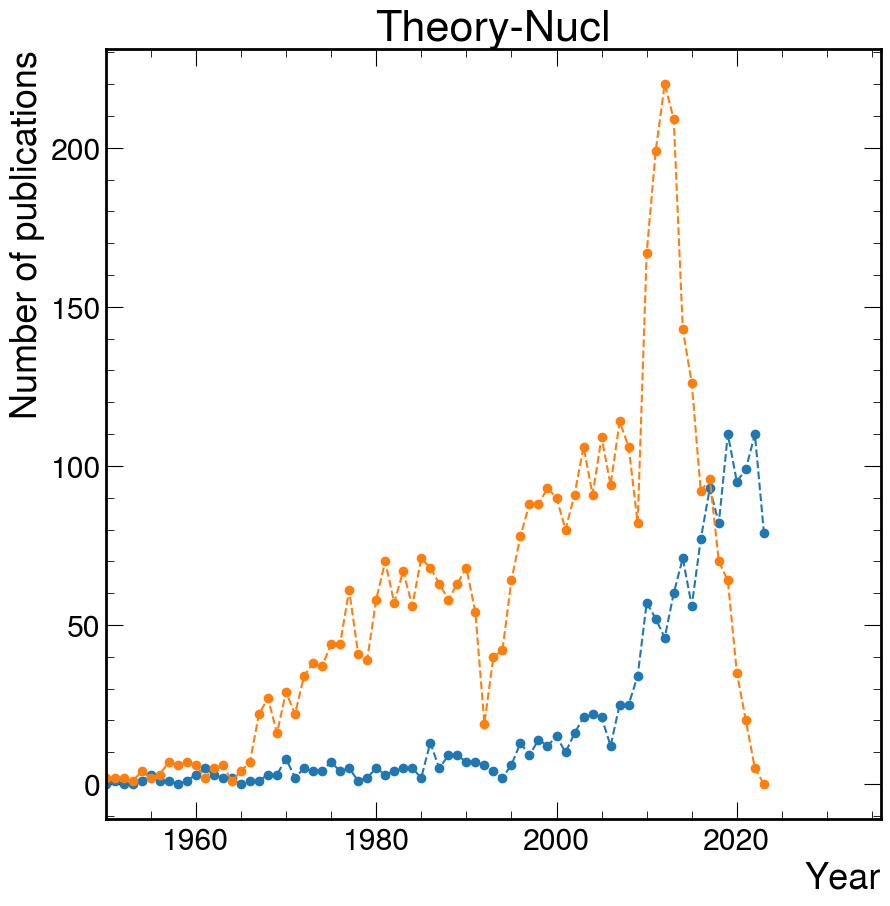

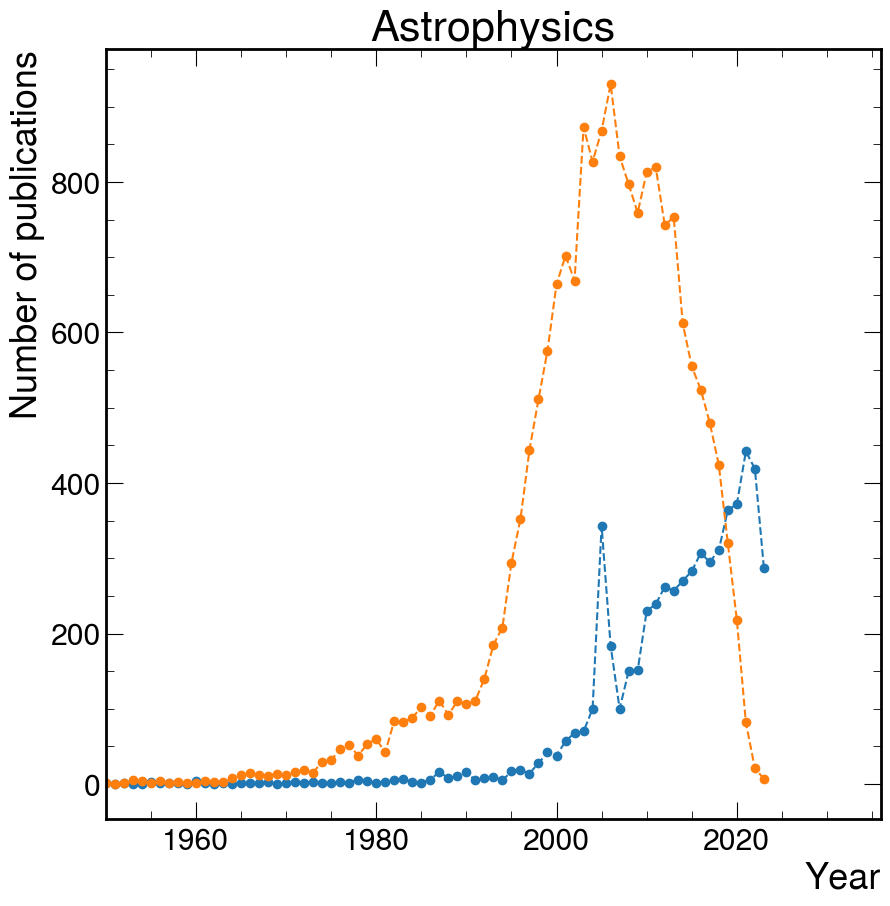

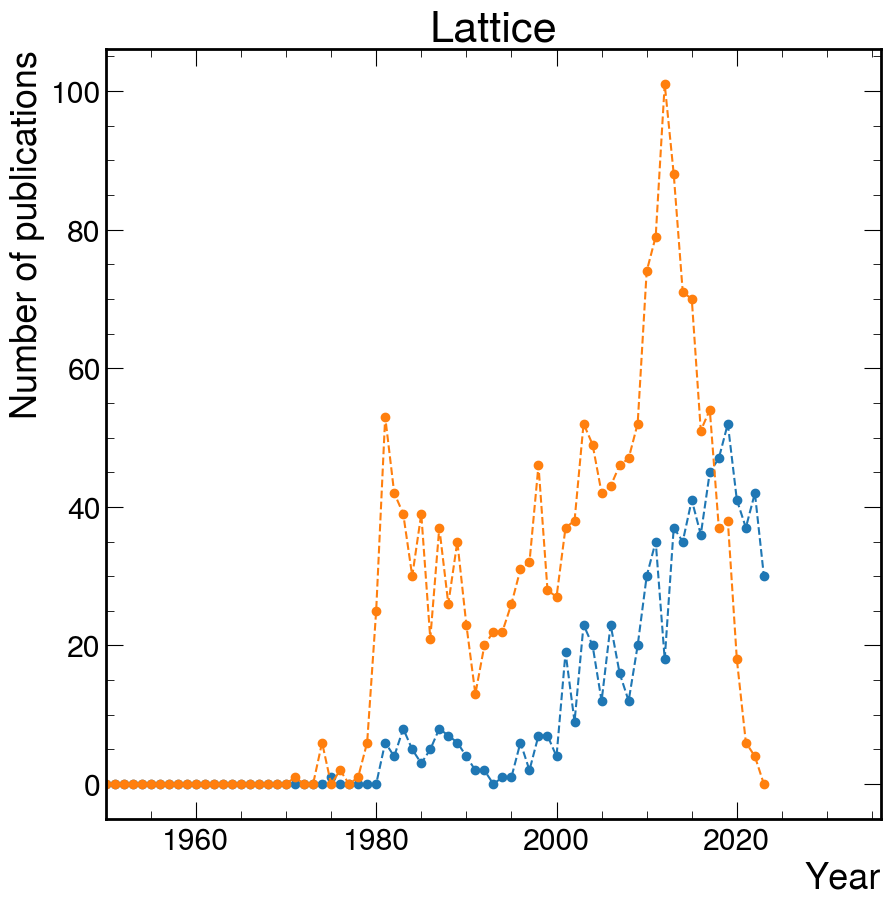

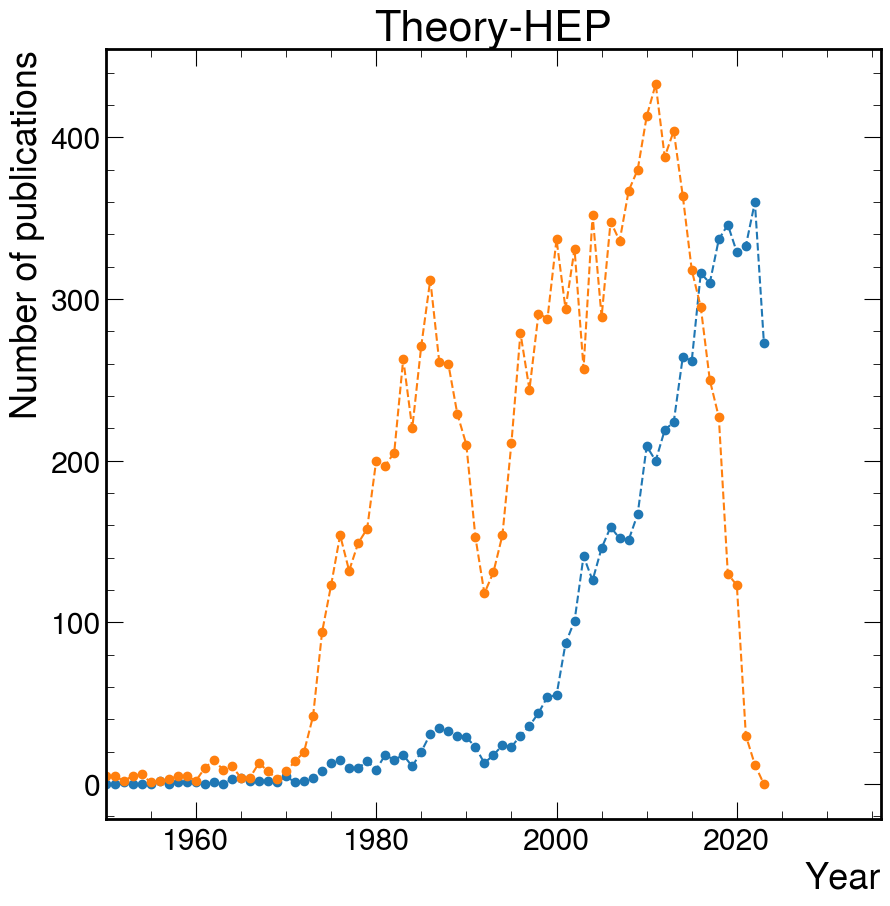

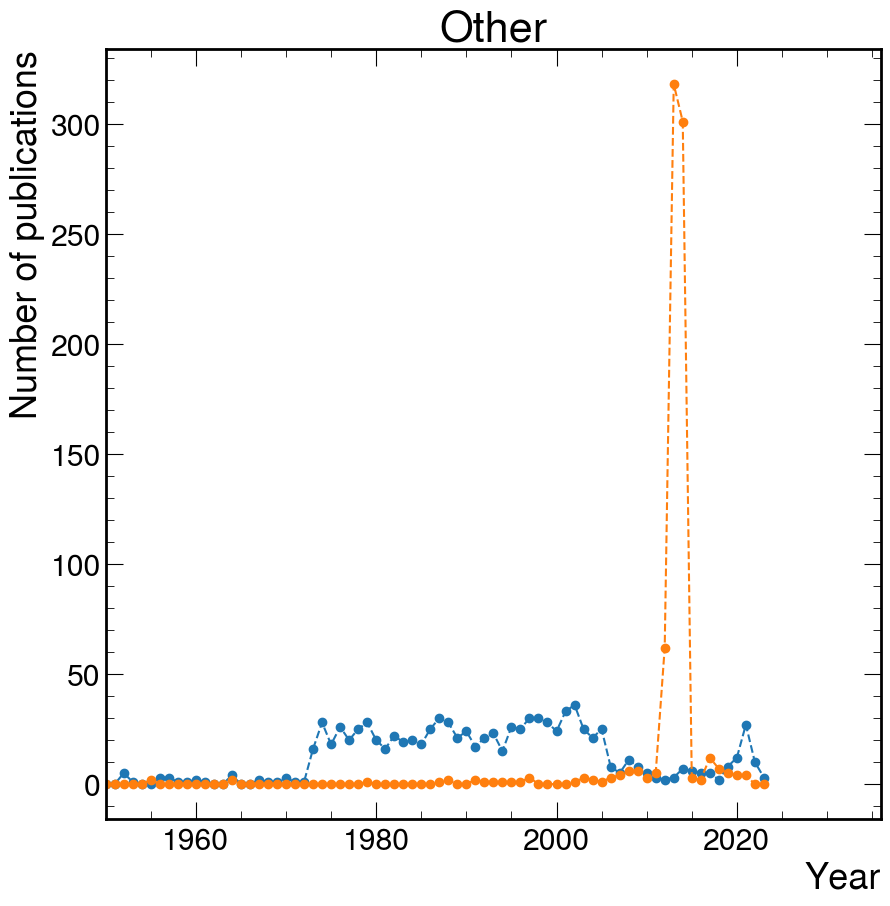

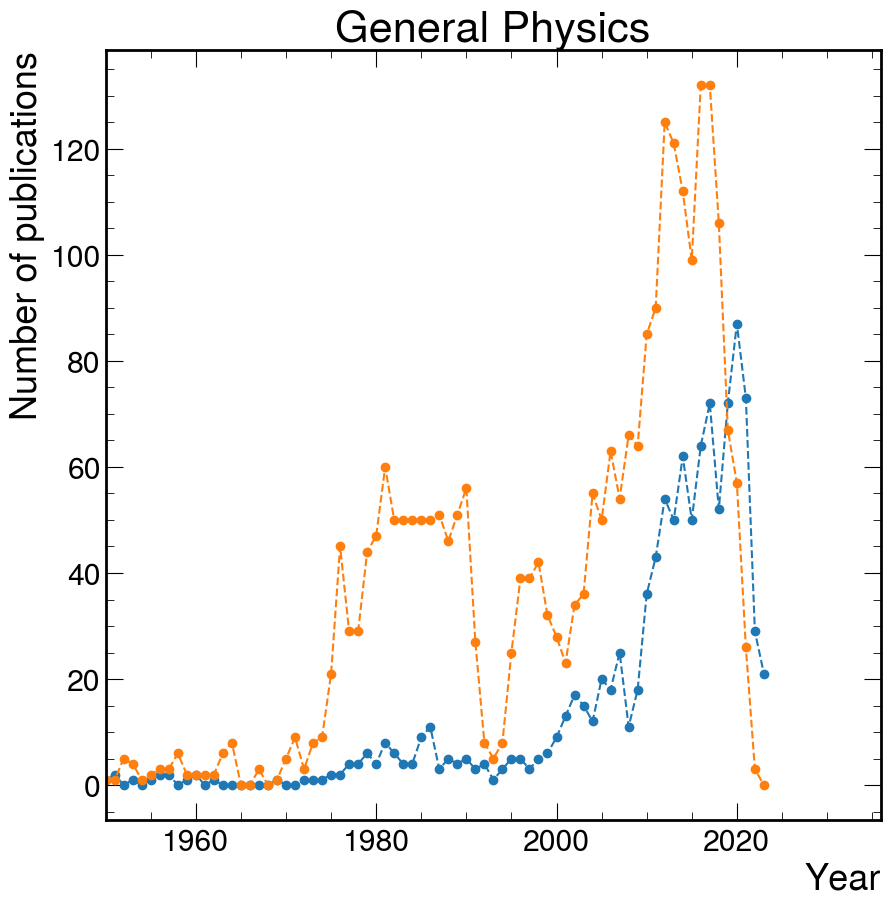

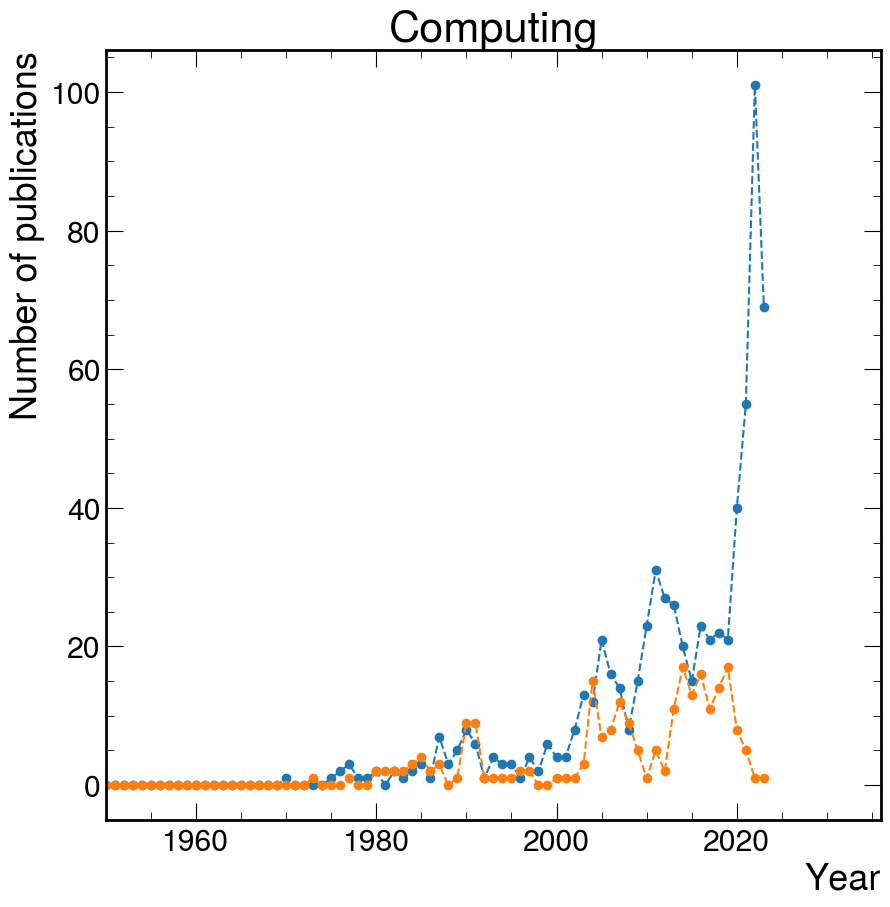

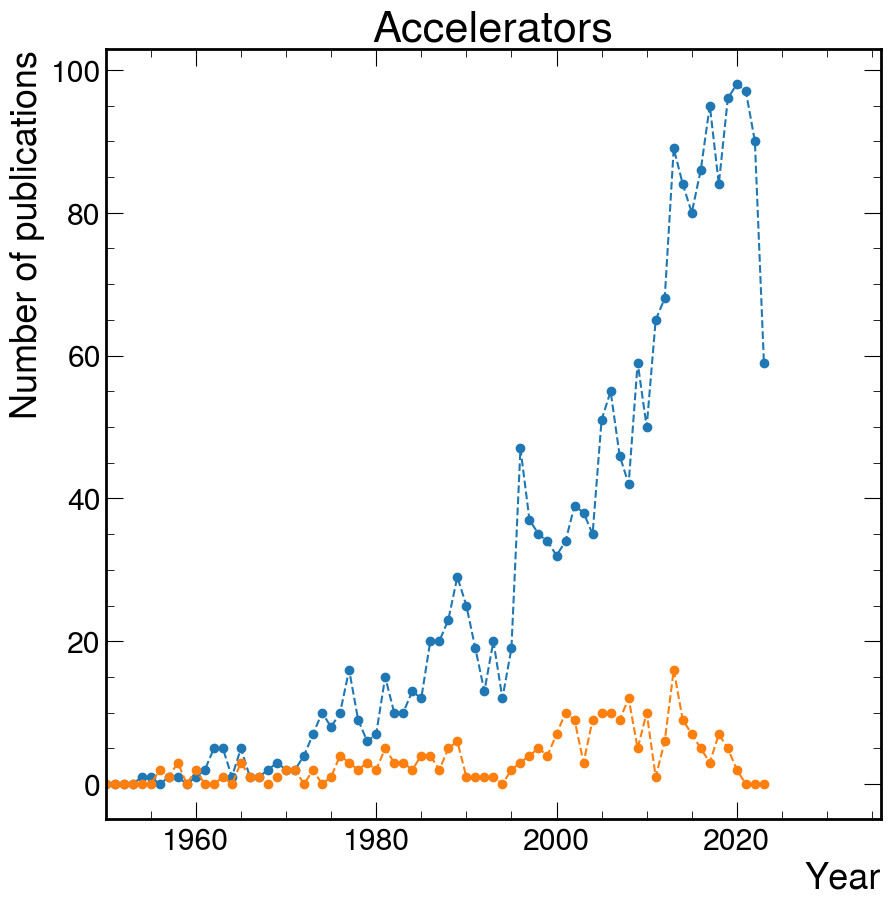

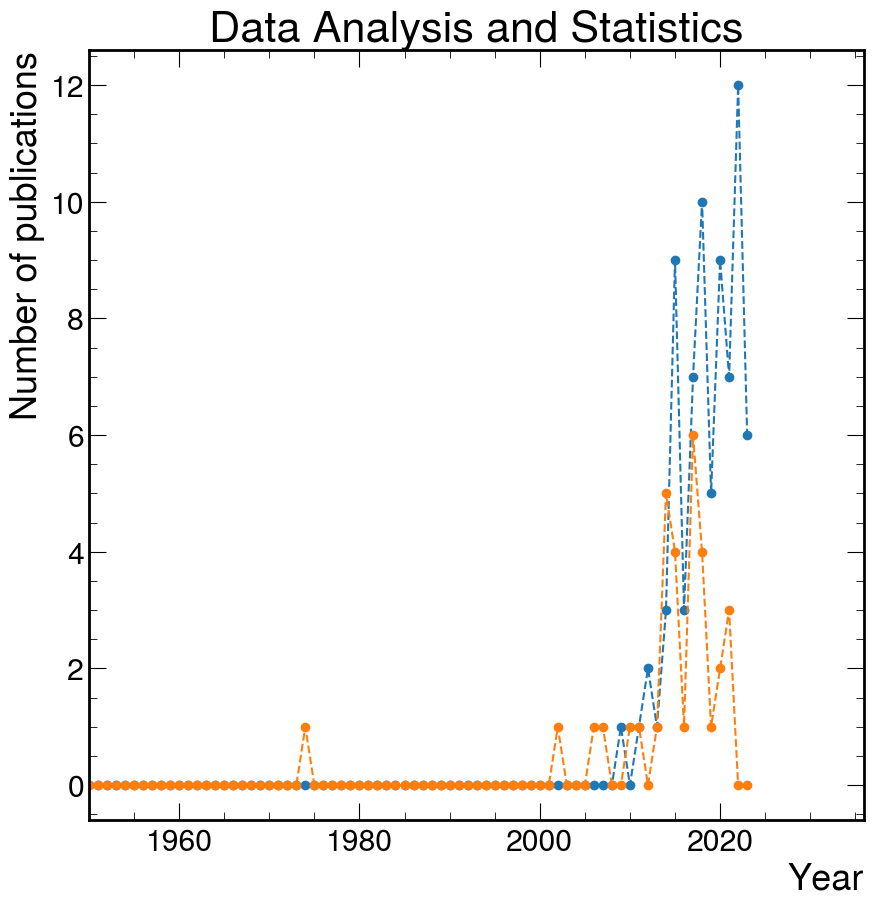

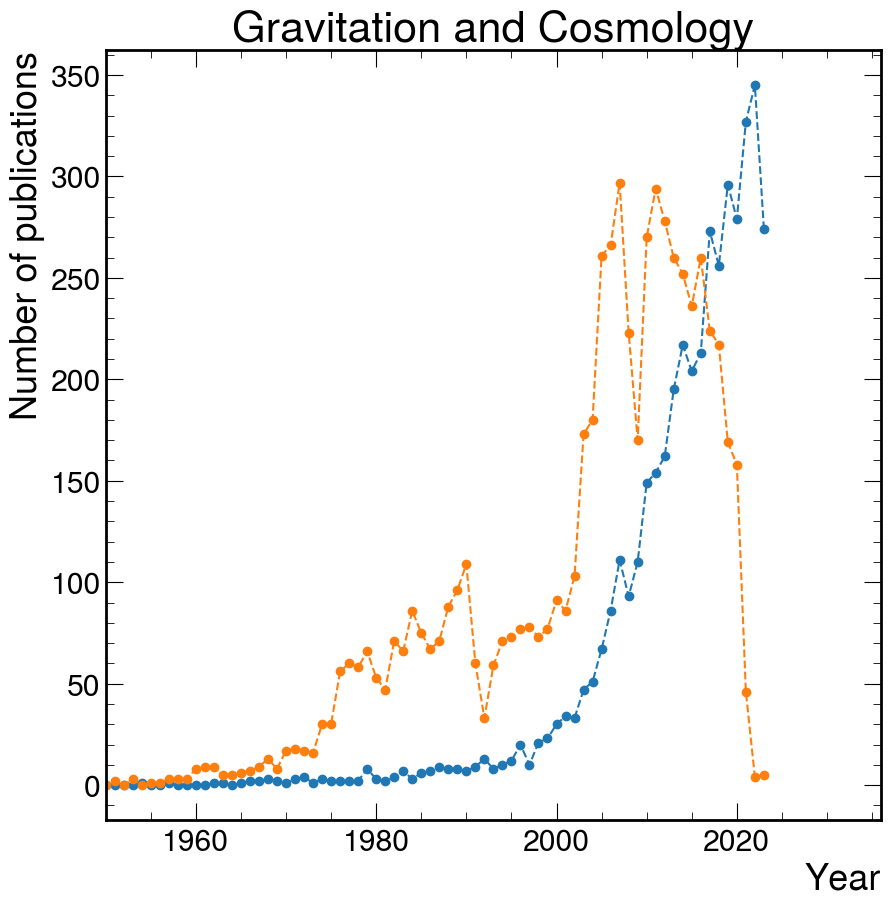

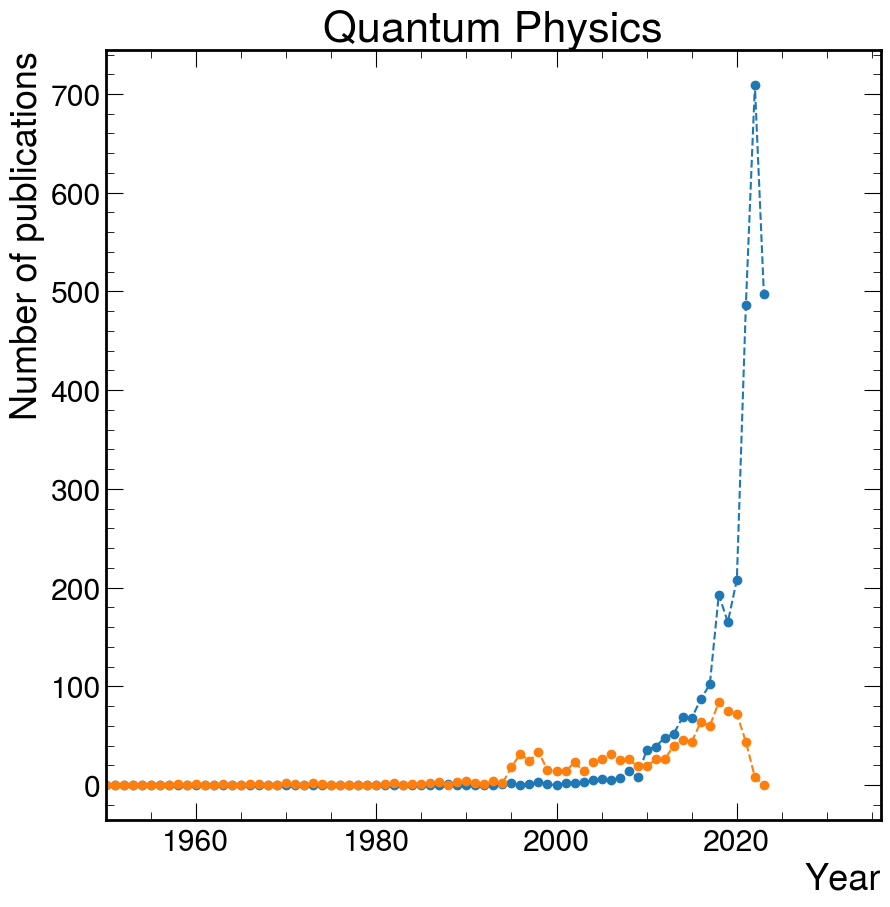

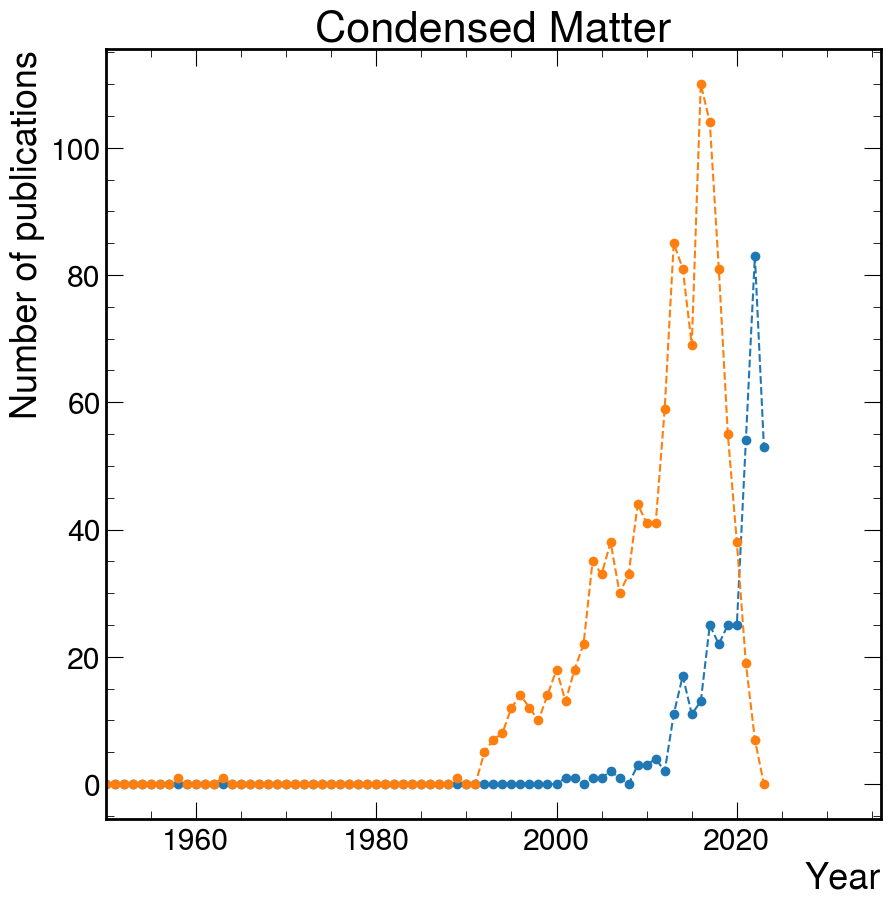

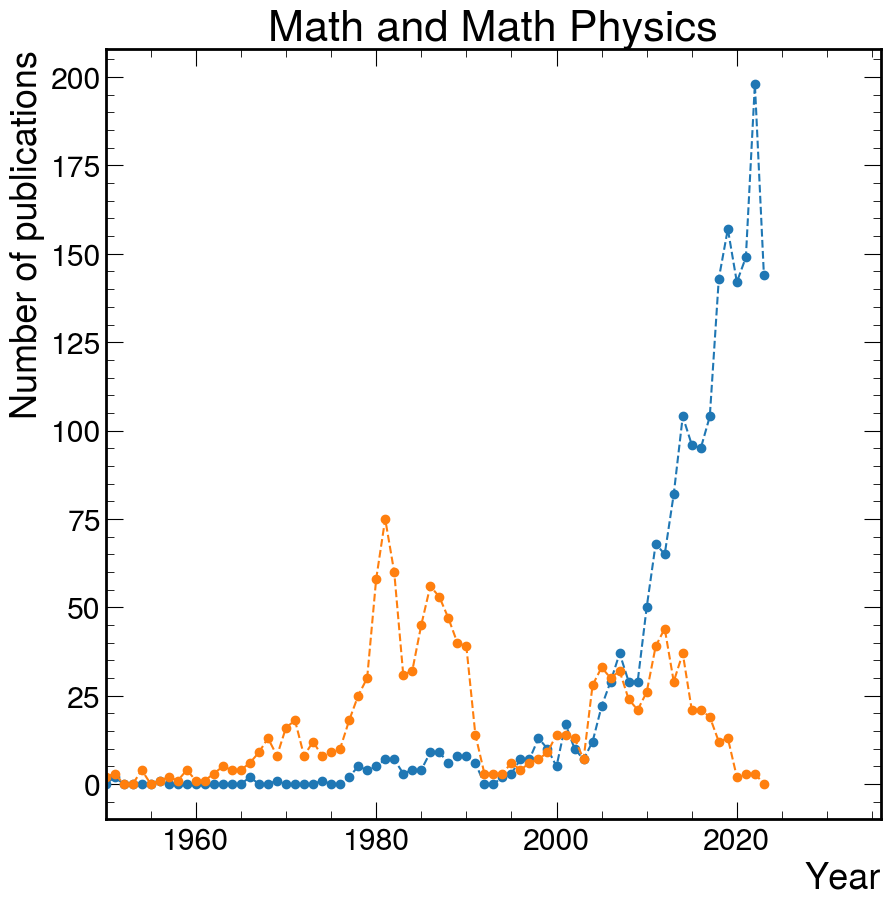

In [19]:
for subject in tqdm(subjects):
    fig,ax = plt.subplots()
    ax:plt.Axes # type: ignore
    ax.set(xlabel='Year', ylabel='Number of publications', title=subject)
    ax.plot(df_len.index, np.array(df_len[subject]['thesis']),'o',ls='--', label='Thesis')
    ax.plot(df_len.index, np.array(df_len[subject]['others']),'o',ls='--', label='Publication (>15 citations)')
    ax.set_xlim(1950,None)
    # ax.legend(loc='upper left')
    # ax.legend(loc='lower right')
    # ax.set_yscale('log')
    fig.savefig(f'/tmp/inspire/{subject}.png', bbox_inches='tight')

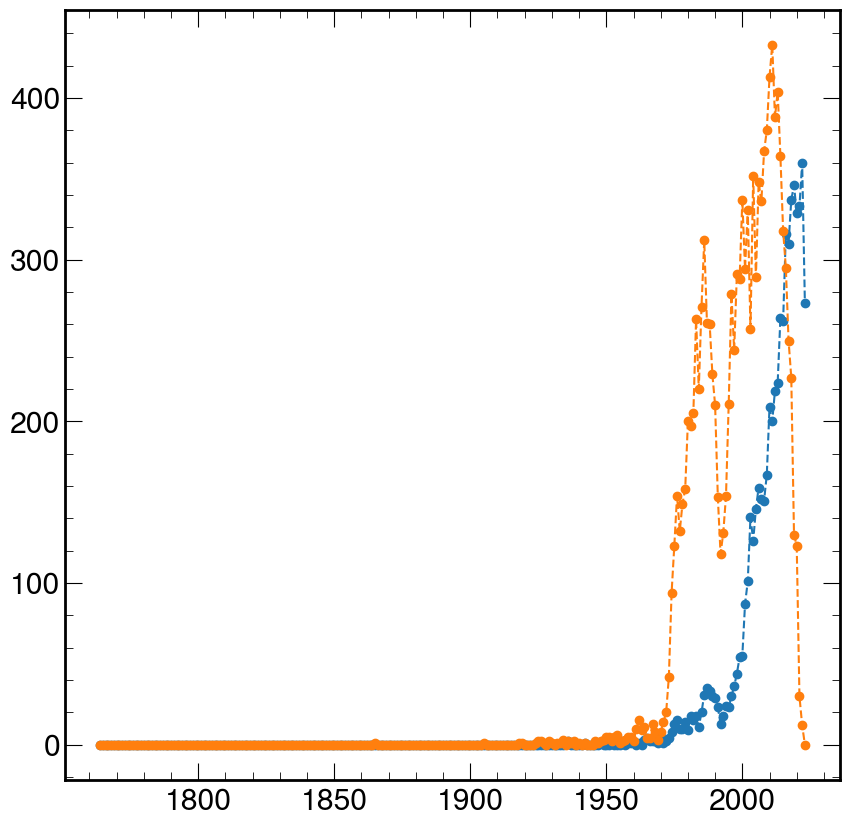

In [20]:
plt.plot(df_len.index, np.array(df_len['Theory-HEP']['thesis']),'o',ls='--')
plt.plot(df_len.index, np.array(df_len['Theory-HEP']['others']),'o',ls='--')
# plt.ylim(0, 450)
# plt.yscale('log')
plt.show()

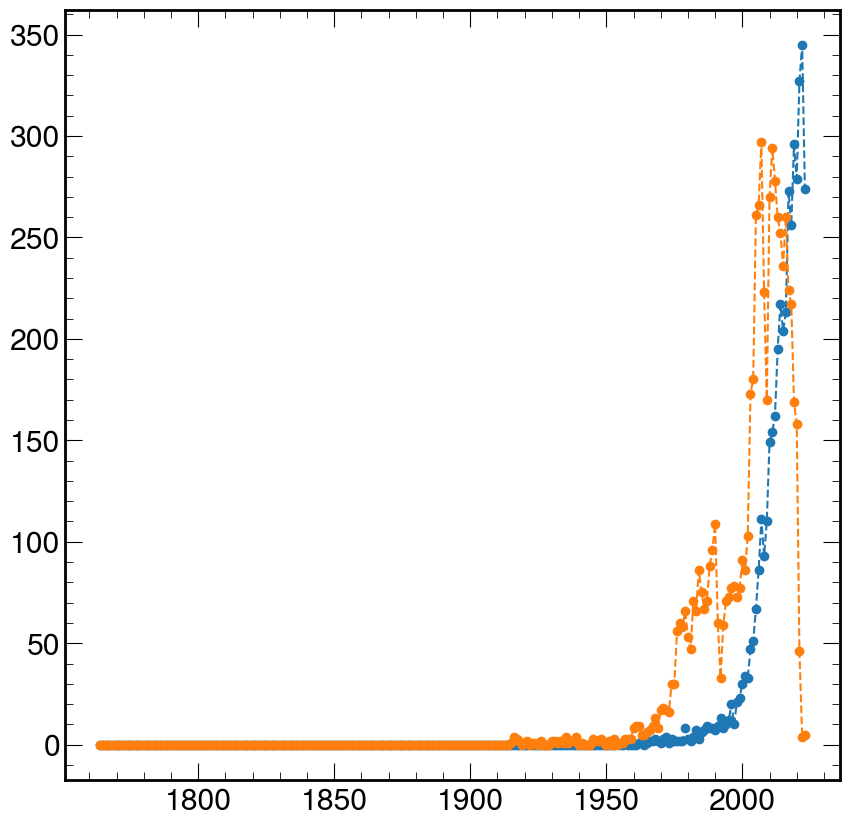

In [21]:
plt.plot(df_len.index, np.array(df_len['Gravitation and Cosmology']['thesis']),'o',ls='--')
plt.plot(df_len.index, np.array(df_len['Gravitation and Cosmology']['others']),'o',ls='--')
# plt.ylim(0, 450)
# plt.yscale('log')
plt.show()